In [1]:
import pandas as pd
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
raw_data_15 = pd.read_csv(r"Seasons\season14-15.csv")#import historical data from 2014/15 season into a panda dataframe 
raw_data_15['Season']=2014# create column based on starting year of the season
raw_data_16 = pd.read_csv(r"Seasons\season15-16.csv")
raw_data_16['Season']=2015
raw_data_17 = pd.read_csv(r"Seasons\season16-17.csv")
raw_data_17['Season']=2016
raw_data_18 = pd.read_csv(r"Seasons\season17-18.csv")
raw_data_18['Season']=2017
raw_data_19 = pd.read_csv(r"Seasons\season18-19.csv")
raw_data_19['Season']=2018
EA_features=pd.read_csv(r"Tables\EA_rating15-20.csv")#import csv file created from EA_players.py
frames=[raw_data_15,raw_data_16,raw_data_17,raw_data_18,raw_data_19]
data=pd.concat(frames).reset_index()#join the historical data seasons into one dataframe

cols_to_consider = ['Season','Date','home_encoded', 'away_encoded',
                'FTHG','FTAG','HTHG', 'HTAG', 'HS',
                'AS', 'HST', 'AST', 'HC','AC','HTR','FTR']

data=data.replace({'H':1,'D':2,'A':0})#replace FTR columns with a number

data['Date']=pd.to_datetime(data['Date'],dayfirst='True')#convert the date to correct format
data.drop(['Div'],axis=1,inplace=True)

encoder = LabelEncoder()#label encoder needed to make the models run
home_encoded = encoder.fit_transform(data['HomeTeam'])#encode the clubs
home_encoded_mapping = dict(
    zip(encoder.classes_, encoder.transform(encoder.classes_).tolist()))#create a mapping for translation of numbers to clubs
data['home_encoded'] = home_encoded

away_encoded = encoder.fit_transform(data['AwayTeam'])
away_encoded_mapping = dict(
    zip(encoder.classes_, encoder.transform(encoder.classes_).tolist()))
data['away_encoded'] = away_encoded


data=data[cols_to_consider]
#merge ratings and historical data on club name and the year of release and season start
EA_features.drop(['index'],axis=1,inplace=True)
data=data.merge(EA_features, left_on=['home_encoded','Season'], right_on=['Club','Release_year'],suffixes=(False, False))
data=data.merge(EA_features, left_on=['away_encoded','Season'], right_on=['Club','Release_year'],suffixes=('_home', '_away'))
#find the difference in rating of the two club playing
data['dif_Overall']=data['Overall_home']-data['Overall_away']
data['dif_Physical']=data['Physical_home']-data['Physical_away']
data['dif_Defending']=data['Defending_home']-data['Defending_away']
data['dif_Pace']=data['Pace_home']-data['Pace_away']
data['dif_Shooting']=data['Shooting_home']-data['Shooting_away']
data['dif_Passing']=data['Passing_home']-data['Passing_away']
data['dif_Dribbling']=data['Dribbling_home']-data['Dribbling_away']
data['dif_GK_diving']=data['GK_diving_home']-data['GK_diving_away']
#drop extra columns
data.drop(columns=[       'Release_year_home', 'Club_home', 'Overall_home', 'Physical_home',
       'Defending_home', 'Pace_home', 'Shooting_home', 'Passing_home',
       'Dribbling_home', 'GK_diving_home', 'Release_year_away', 'Club_away',
       'Overall_away', 'Physical_away', 'Defending_away', 'Pace_away',
       'Shooting_away', 'Passing_away', 'Dribbling_away', 'GK_diving_away','Season'],inplace=True)

data=data.sort_values(by='Date')

In [3]:
#used to find the moving averages, iterate through dates to find the avereage of the home club stats
def average_season(string):
    stats=[]
    for i, j in zip(data["Date"],data['home_encoded']):
        oi = data.loc[data["Date"]<i]
        oi = oi.loc[oi["home_encoded"]==j]
        oi = oi[string].mean()
        stats.append(oi)

    data["avg_"+string] = pd.DataFrame(np.array(stats))
        
def average_last_3(variable):
    stats = []
    for i, j in zip(data["Date"],data["home_encoded"]):
        oi = data.loc[data["Date"]<i]
        oi = oi.loc[oi["home_encoded"]==j]
        oi= oi.reset_index(drop=True)
        oi = oi[-3:]
        oi = oi[variable].mean()
        stats.append(oi)

    data["last_3_avg_"+variable] = pd.DataFrame(np.array(stats))    
#find the points gain in a period using the moving averages shown above    
def sequence_5():
    sequences = []
    for i, j in zip(data["Date"],data["home_encoded"]):
        oi = data.loc[data["Date"]<i]
        oi = oi.loc[oi["home_encoded"]==j]
        oi= oi.reset_index(drop=True)
        oi = oi[-5:]
        di = {1:3,
             2:1,
             0:0}
        oi = oi.replace({"FTR":di})
        oi = oi.FTR.sum()
        sequences.append(oi)
    data["pnts_lst_5"] = pd.DataFrame(np.array(sequences))
    
def sequence_3():
    sequences = []
    for i, j in zip(data["Date"],data["home_encoded"]):
        oi = data.loc[data["Date"]<i]
        oi = oi.loc[oi["home_encoded"]==j]
        oi= oi.reset_index(drop=True)
        oi = oi[-3:]
        di = {1:3,
             2:1,
             0:0}
        oi = oi.replace({"FTR":di})
        oi = oi.FTR.sum()
        sequences.append(oi)
    data["pnts_lst_3"] = pd.DataFrame(np.array(sequences))
    
    
def sequence_1():

    sequences = []
    for i, j in zip(data["Date"],data["home_encoded"]):
        oi = data.loc[data["Date"]<i]
        oi = oi.loc[oi["home_encoded"]==j]
        oi= oi.reset_index(drop=True)
        oi = oi[-1:]
        di = {1:3,
             2:1,
             0:0}
        oi = oi.replace({"FTR":di})
        oi = oi.FTR.sum()
        sequences.append(oi)
    data["pnts_lst_game"] = pd.DataFrame(np.array(sequences))

In [4]:
stats_average = data.drop(columns=['Date','home_encoded', 'away_encoded', 'FTR',
                                    'dif_Overall', 'dif_Physical', 'dif_Defending', 'dif_Pace',
                                   'dif_Shooting', 'dif_Passing', 'dif_Dribbling', 'dif_GK_diving'])

for i in stats_average.columns:
    average_season(i)
    average_last_3(i)
    
sequence_5()
sequence_3()
sequence_1()

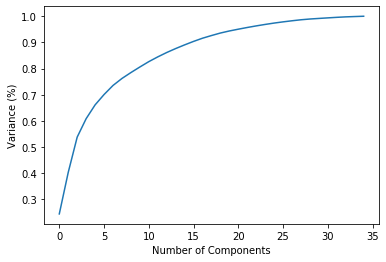

In [5]:
X=data.drop(['Date','FTHG', 'FTAG', 'HTHG','HTAG', 'HS',
             'AS', 'HST', 'AST', 'HC', 'AC', 'HTR', 'FTR'],axis=1)#drop columns of the actual match for a moving average

X.fillna(0,inplace=True)
y=data['FTR']# y set to ftr for results 

scaler = StandardScaler()# reduce dimmensionality of features
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=35).fit(X_scaled)
X_pca = pca.transform(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()
# X.to_csv('X-20.csv',index=False)

In [6]:
svc_classifier = SVC(random_state=100, kernel='rbf')
lr_classifier = LogisticRegression(multi_class='ovr', max_iter=500)
nbClassifier = GaussianNB()
dtClassifier = DecisionTreeClassifier()
rfClassifier = RandomForestClassifier()
#split the data between test and training
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y,test_size=0.3,random_state=3,shuffle=None)# random state set to 3 for repeatability

# NB

In [7]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 verbose=1, 
                cv=10, n_jobs=-1) 
gs_NB.fit(X_train, Y_train)#fit the training data to model

print(gs_NB.best_params_)
print("-" * 100)
print(gs_NB.best_estimator_)
print("-" * 100)


Y_rf = gs_NB.predict(X_test)#predict the results using the model selected
F=classification_report(Y_test, Y_rf)
print(F)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s


{'var_smoothing': 0.8111308307896871}
----------------------------------------------------------------------------------------------------
GaussianNB(var_smoothing=0.8111308307896871)
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.42      0.47       106
           1       0.55      0.87      0.67       182
           2       0.00      0.00      0.00        83

    accuracy                           0.54       371
   macro avg       0.36      0.43      0.38       371
weighted avg       0.42      0.54      0.46       371



[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished


# LR

In [8]:
lr_classifier = LogisticRegression()
param_lr = {"C":[100,25, 10, 1.0, 0.1, 0.01], "penalty":["l1","l2"],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }


gs_LR = LogisticRegression()
gs_LR = GridSearchCV(lr_classifier, param_grid=param_lr, refit = True, verbose = 3, cv=10) 
gs_LR.fit(X_train, Y_train)
print(gs_LR.best_params_)
print("-" * 100)
print(gs_LR.best_estimator_)
print("-" * 100)

Y_rf = gs_LR.predict(X_test)
Z=classification_report(Y_test, Y_rf)
print(Z)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100

[CV] . C=100, penalty=l2, solver=newton-cg, score=0.535, total=   0.0s
[CV] C=100, penalty=l2, solver=newton-cg .............................
[CV] . C=100, penalty=l2, solver=newton-cg, score=0.547, total=   0.0s
[CV] C=100, penalty=l2, solver=newton-cg .............................
[CV] . C=100, penalty=l2, solver=newton-cg, score=0.430, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.517, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.575, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.517, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] ..... C=100, penalty=l2, solver=lbfgs, score=0.483, total=   0.0s
[CV] C=100, penalty=l2, solver=lbfgs .................................
[CV] .

[CV] ....... C=25, penalty=l1, solver=saga, score=0.517, total=   0.1s
[CV] C=25, penalty=l1, solver=saga ...................................
[CV] ....... C=25, penalty=l1, solver=saga, score=0.575, total=   0.1s
[CV] C=25, penalty=l1, solver=saga ...................................
[CV] ....... C=25, penalty=l1, solver=saga, score=0.517, total=   0.1s
[CV] C=25, penalty=l1, solver=saga ...................................
[CV] ....... C=25, penalty=l1, solver=saga, score=0.483, total=   0.1s
[CV] C=25, penalty=l1, solver=saga ...................................
[CV] ....... C=25, penalty=l1, solver=saga, score=0.540, total=   0.1s
[CV] C=25, penalty=l1, solver=saga ...................................
[CV] ....... C=25, penalty=l1, solver=saga, score=0.512, total=   0.1s
[CV] C=25, penalty=l1, solver=saga ...................................
[CV] ....... C=25, penalty=l1, solver=saga, score=0.477, total=   0.1s
[CV] C=25, penalty=l1, solver=saga ...................................
[CV] .

[CV] ........ C=10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ........ C=10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ........ C=10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ........ C=10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ........ C=10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ........ C=10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] ........ C=10, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, penalty=l1, solver=lbfgs ..................................
[CV] .

[CV] .. C=10, penalty=l2, solver=liblinear, score=0.517, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.483, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.552, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.500, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.488, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.523, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .. C=10, penalty=l2, solver=liblinear, score=0.570, total=   0.0s
[CV] C=10, penalty=l2, solver=liblinear ..............................
[CV] .

[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.529, total=   0.1s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.494, total=   0.1s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.517, total=   0.1s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.500, total=   0.1s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.512, total=   0.1s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.512, total=   0.1s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.547, total=   0.1s
[CV] C=1.0, penalty=l1, solver=saga ..................................
[CV] .

[CV] ...... C=0.1, penalty=l1, solver=saga, score=0.517, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ...... C=0.1, penalty=l1, solver=saga, score=0.460, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ...... C=0.1, penalty=l1, solver=saga, score=0.575, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ...... C=0.1, penalty=l1, solver=saga, score=0.529, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ...... C=0.1, penalty=l1, solver=saga, score=0.552, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ...... C=0.1, penalty=l1, solver=saga, score=0.512, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] ...... C=0.1, penalty=l1, solver=saga, score=0.547, total=   0.0s
[CV] C=0.1, penalty=l1, solver=saga ..................................
[CV] .

[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.570, total=   0.0s
[CV] C=0.1, penalty=l2, solver=saga ..................................
[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.430, total=   0.0s
[CV] C=0.01, penalty=l1, solver=newton-cg ............................
[CV] .. C=0.01, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, penalty=l1, solver=newton-cg ............................
[CV] .. C=0.01, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, penalty=l1, solver=newton-cg ............................
[CV] .. C=0.01, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, penalty=l1, solver=newton-cg ............................
[CV] .. C=0.01, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, penalty=l1, solver=newton-cg ............................
[CV] .. C=0.01, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.01, penalty=l1, solver=newton-cg ............................
[CV] .

[CV]  C=0.01, penalty=l2, solver=newton-cg, score=0.465, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.529, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.494, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.540, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.529, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.563, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .... C=0.01, penalty=l2, solver=lbfgs, score=0.500, total=   0.0s
[CV] C=0.01, penalty=l2, solver=lbfgs ................................
[CV] .

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   10.3s finished


# DT

In [9]:
parameter_grid ={'criterion' : ['gini', 'entropy'],
'max_depth' :range(1,12),
'random_state':[0, 1, 2, 3, 4, 5, 10, 15,20,35,50],
'min_samples_split':range(1,10),
'min_samples_leaf': range(1,6),
}    


dt_Model = DecisionTreeClassifier()
dt_Grid = GridSearchCV(dt_Model,param_grid=parameter_grid,cv=10,verbose=1,n_jobs=-1)
dt_Grid.fit(X_train, Y_train)
print(dt_Grid.best_params_)
print("-" * 100)
print(dt_Grid.best_estimator_)
print("-" * 100)

Y_rf = dt_Grid.predict(X_test)
Z=classification_report(Y_test, Y_rf)
print(Z)


Fitting 10 folds for each of 10890 candidates, totalling 108900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 22640 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 29648 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 35048 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 41648 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 49448 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 61136 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 81156 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 95984 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 108900 out of 108900 | elapsed:  5.8min finished


{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}
----------------------------------------------------------------------------------------------------
DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       106
           1       0.54      0.81      0.65       182
           2       0.00      0.00      0.00        83

    accuracy                           0.53       371
   macro avg       0.34      0.42      0.37       371
weighted avg       0.40      0.53      0.45       371



# RF

In [10]:
# Number of trees in random forest
n_estimators = [100, 300, 500, 800, 1200]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]


param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)
rf_Grid.fit(X_train, Y_train)
print(rf_Grid.best_params_)
print("-" * 100)
print(rf_Grid.best_estimator_)
print("-" * 100)

Y_rf = rf_Grid.predict(X_test)
y=classification_report(Y_test, Y_rf)
print(y)


Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 25.2min finished


{'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 800}
----------------------------------------------------------------------------------------------------
RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=2,
                       n_estimators=800)
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.42      0.43       106
           1       0.55      0.80      0.65       182
           2       0.29      0.02      0.04        83

    accuracy                           0.52       371
   macro avg       0.43      0.41      0.38       371
weighted avg       0.46      0.52      0.45       371



# SVC

In [11]:
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [1,0.001, 0.0001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)

print(grid.best_params_)
print("-" * 100)
print(grid.best_estimator_)
print("-" * 100)

Y_rf = grid.predict(X_test)
y=classification_report(Y_test, Y_rf)
print(y)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .

[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV] ................... C=10, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV] ................... C=10, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV] ................... C=10, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV] ................... C=10, gamma=0.001, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.001, kernel=poly ..................................
[CV] .

[CV] .................. C=100, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=100, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=100, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    6.6s finished


# Tuning

In [12]:
gs_NB_Grid = GaussianNB()
gs_NB_Grid=GaussianNB(var_smoothing=0.05)
NBOpt = gs_NB_Grid.fit(X_train, Y_train)
Y_nb = NBOpt.predict(X_test)
F=classification_report(Y_test, Y_nb)
print(F)

              precision    recall  f1-score   support

           0       0.44      0.53      0.48       106
           1       0.58      0.74      0.65       182
           2       0.36      0.06      0.10        83

    accuracy                           0.53       371
   macro avg       0.46      0.44      0.41       371
weighted avg       0.49      0.53      0.48       371



In [13]:
gs_LR = LogisticRegression()
gs_LR = LogisticRegression(C=0.1, penalty='l1', solver='saga')                                
LROpt = gs_LR.fit(X_train, Y_train)
Y_lr = LROpt.predict(X_test)
Z=classification_report(Y_test, Y_lr)
print(Z)

              precision    recall  f1-score   support

           0       0.48      0.56      0.52       106
           1       0.58      0.77      0.67       182
           2       0.33      0.02      0.04        83

    accuracy                           0.54       371
   macro avg       0.47      0.45      0.41       371
weighted avg       0.50      0.54      0.48       371



In [14]:
dt_Grid = DecisionTreeClassifier()
dt_Grid = DecisionTreeClassifier(criterion='entropy',max_depth=3,min_samples_leaf=1, min_samples_split=2,random_state=0)                                
dtOpt = dt_Grid.fit(X_train, Y_train)
Y_dt = dtOpt.predict(X_test)
p=classification_report(Y_test, Y_dt)
print(p)


              precision    recall  f1-score   support

           0       0.49      0.37      0.42       106
           1       0.56      0.75      0.64       182
           2       0.27      0.16      0.20        83

    accuracy                           0.51       371
   macro avg       0.44      0.42      0.42       371
weighted avg       0.47      0.51      0.48       371



In [15]:
rf_Grid = RandomForestClassifier(random_state = 1, max_depth = 8,bootstrap=True,max_features='auto',     
                        n_estimators = 1200, min_samples_split = 2, min_samples_leaf = 1)
                                   
RFlOpt = rf_Grid.fit(X_train, Y_train)
Y_rf = RFlOpt.predict(X_test)
y=classification_report(Y_test, Y_rf)
print(y)

              precision    recall  f1-score   support

           0       0.49      0.39      0.43       106
           1       0.54      0.84      0.66       182
           2       0.33      0.01      0.02        83

    accuracy                           0.53       371
   macro avg       0.45      0.41      0.37       371
weighted avg       0.48      0.53      0.45       371



In [16]:
grid = SVC(C = 10,gamma=0.01,kernel='rbf')
SVCOpt = grid.fit(X_train,Y_train)
Y_sv = SVCOpt.predict(X_test)
d=classification_report(Y_test, Y_sv)
print(d)

              precision    recall  f1-score   support

           0       0.45      0.46      0.46       106
           1       0.56      0.64      0.60       182
           2       0.23      0.14      0.18        83

    accuracy                           0.48       371
   macro avg       0.41      0.42      0.41       371
weighted avg       0.45      0.48      0.46       371



# Features Importance

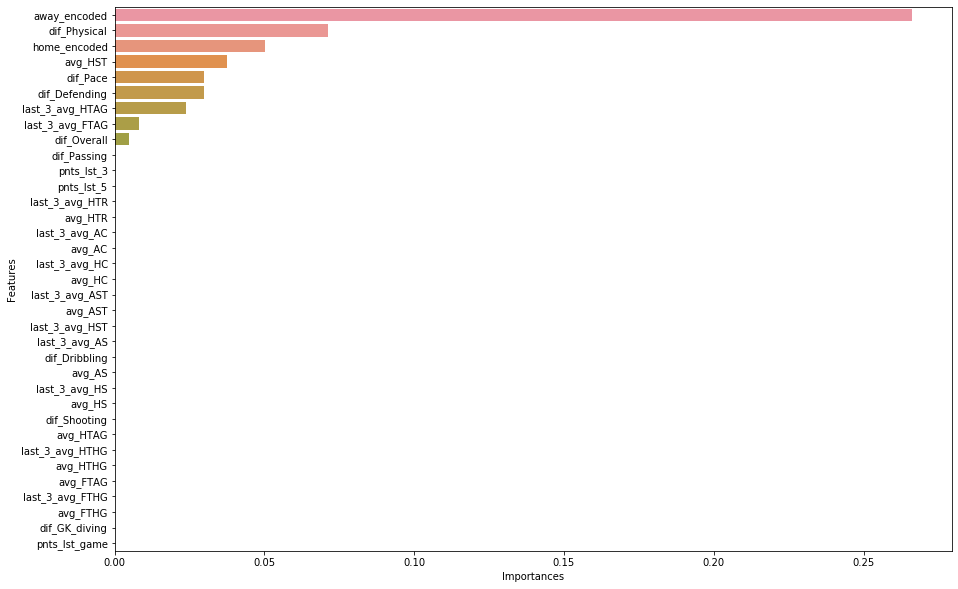

In [17]:
importance = abs(LROpt.coef_[0])

list_1 = []
list_2 = []
for i,j in zip(importance,X.columns):
    list_1.append(str(j))
    list_2.append(i)
    
df_name = pd.DataFrame(list_1,columns=["Features"])
df_number = pd.DataFrame(list_2,columns=["Importances"])

df_ranking = pd.concat([df_name, df_number], axis=1)
df_final = df_ranking.sort_values("Importances",ascending=False).reset_index(drop=True)
df_final.Features = df_final.Features.astype(str)
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="Importances", y="Features", data=df_final)

# predict Final Season Standing

In [18]:
raw_data_20 = pd.read_csv(r"Seasons\seasons19-20.csv")
Y_test=raw_data_20['FTR']
v = pd.read_csv(r"Tables\Book2.csv")#csv made up of latest moving averages from the previous season 2018/2019

gs_LR = LogisticRegression()
gs_LR = LogisticRegression(C=10, penalty='l1', solver='saga')                                
LROpt = gs_LR.fit(X_train, Y_train)

Y_lr = LROpt.predict(v)
print("-" * 100)
print(classification_report(Y_test, Y_lr))




----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.32      0.78      0.46       116
           1       0.54      0.24      0.33       172
           2       0.33      0.10      0.15        92

    accuracy                           0.37       380
   macro avg       0.40      0.37      0.31       380
weighted avg       0.42      0.37      0.33       380



In [19]:
#print the table of results

Y_rf=pd.DataFrame(Y_lr)
season_predict=v[['home_encoded','away_encoded']]
season_predict['FTR']=Y_rf.to_numpy()
season_predict.loc[(season_predict['FTR']==1),'hp']=0
season_predict.loc[(season_predict['FTR']==2),'hp']=1
season_predict.loc[(season_predict['FTR']==0),'hp']=3


season_predict.loc[(season_predict['FTR']==0),'ap']=0
season_predict.loc[(season_predict['FTR']==2),'ap']=1
season_predict.loc[(season_predict['FTR']==1),'ap']=3

season_predict


def homeresults(team,df):
    teamsum=0
    for i in range(len(df)):
        if team == df.loc[i,['home_encoded']].values[0]:
            teamsum+=df.loc[i,['hp']].values[0]
    return teamsum

def awayresults(team,df):
    teamsum=0
    for i in range(len(df)):
        if team == df.loc[i,['away_encoded']].values[0]:
            teamsum+=df.loc[i,['ap']].values[0]
    return teamsum

tally={}
for i in pd.unique(season_predict['home_encoded']).tolist():
    for name,team in home_encoded_mapping.items():
        if team == i:    
            total=0
            total+=homeresults(i,season_predict)
            total+=awayresults(i,season_predict)
            tally[name]=total
    
var=sorted(tally.items(),key=lambda x: x[1],reverse=True)
var

[('Liverpool', 90.0),
 ('Man City', 90.0),
 ('Leicester', 87.0),
 ('Bournemouth', 81.0),
 ('Brighton', 75.0),
 ('Newcastle', 75.0),
 ('Arsenal', 69.0),
 ('Man United', 56.0),
 ('Watford', 56.0),
 ('Everton', 53.0),
 ('Aston Villa', 51.0),
 ('Crystal Palace', 47.0),
 ('Tottenham', 45.0),
 ('West Ham', 41.0),
 ('Chelsea', 38.0),
 ('Wolves', 35.0),
 ('Norwich', 34.0),
 ('Burnley', 33.0),
 ('Stoke', 29.0),
 ('Southampton', 28.0)]

 # Predict FTHG -best predictor

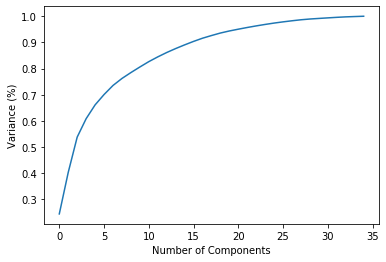

In [20]:
X=data.drop(['Date','FTHG', 'FTAG', 'HTHG','HTAG', 'HS',
             'AS', 'HST', 'AST', 'HC', 'AC', 'HTR', 'FTR'],axis=1)

X.fillna(0,inplace=True)
y=data['FTHG']# change for want is wanted

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=35).fit(X_scaled)
X_pca = pca.transform(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y,test_size=0.3,random_state=1,shuffle=None)

In [21]:
lr_classifier = LogisticRegression()
param_lr = {"C":[100, 10, 1.0, 0.1, 0.01], "penalty":["l1","l2"],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }


gs_LR = LogisticRegression()
gs_LR = GridSearchCV(lr_classifier, param_grid=param_lr, refit = True, verbose = 3, cv=10) 
gs_LR.fit(X_train, Y_train)
print(gs_LR.best_params_)
print("-" * 100)
print(gs_LR.best_estimator_)
print("-" * 100)
print(gs_LR.best_score_)
print("-" * 100)

Y_lr = gs_LR.predict(X_test)
Z=classification_report(Y_test, Y_lr)
print(Z)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=100, penalty=l1, solver=newton-cg .............................
[CV] ... C=100

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] . C=100, penalty=l1, solver=liblinear, score=0.287, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.276, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.368, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.186, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.267, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.302, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] . C=100, penalty=l1, solver=liblinear, score=0.279, total=   0.1s
[CV] C=100, penalty=l1, solver=liblinear .............................
[CV] .

[CV] ....... C=100, penalty=l2, solver=sag, score=0.276, total=   0.1s
[CV] C=100, penalty=l2, solver=sag ...................................
[CV] ....... C=100, penalty=l2, solver=sag, score=0.264, total=   0.1s
[CV] C=100, penalty=l2, solver=sag ...................................
[CV] ....... C=100, penalty=l2, solver=sag, score=0.368, total=   0.1s
[CV] C=100, penalty=l2, solver=sag ...................................
[CV] ....... C=100, penalty=l2, solver=sag, score=0.174, total=   0.1s
[CV] C=100, penalty=l2, solver=sag ...................................
[CV] ....... C=100, penalty=l2, solver=sag, score=0.256, total=   0.1s
[CV] C=100, penalty=l2, solver=sag ...................................
[CV] ....... C=100, penalty=l2, solver=sag, score=0.302, total=   0.1s
[CV] C=100, penalty=l2, solver=sag ...................................
[CV] ....... C=100, penalty=l2, solver=sag, score=0.291, total=   0.1s
[CV] C=100, penalty=l2, solver=sag ...................................
[CV] .

[CV] ....... C=10, penalty=l1, solver=saga, score=0.241, total=   0.2s
[CV] C=10, penalty=l1, solver=saga ...................................
[CV] ....... C=10, penalty=l1, solver=saga, score=0.333, total=   0.2s
[CV] C=10, penalty=l1, solver=saga ...................................
[CV] ....... C=10, penalty=l1, solver=saga, score=0.287, total=   0.2s
[CV] C=10, penalty=l1, solver=saga ...................................
[CV] ....... C=10, penalty=l1, solver=saga, score=0.264, total=   0.2s
[CV] C=10, penalty=l1, solver=saga ...................................
[CV] ....... C=10, penalty=l1, solver=saga, score=0.368, total=   0.2s
[CV] C=10, penalty=l1, solver=saga ...................................
[CV] ....... C=10, penalty=l1, solver=saga, score=0.198, total=   0.2s
[CV] C=10, penalty=l1, solver=saga ...................................
[CV] ....... C=10, penalty=l1, solver=saga, score=0.256, total=   0.2s
[CV] C=10, penalty=l1, solver=saga ...................................
[CV] .

[CV] ....... C=10, penalty=l2, solver=saga, score=0.291, total=   0.1s
[CV] C=10, penalty=l2, solver=saga ...................................
[CV] ....... C=10, penalty=l2, solver=saga, score=0.314, total=   0.1s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] .

[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.302, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................
[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.279, total=   0.1s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................
[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.314, total=   0.1s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.253, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.333, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.299, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.276, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .

[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.384, total=   0.0s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.442, total=   0.0s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] . C=0.1, penalty=l1, solver=liblinear, score=0.349, total=   0.0s
[CV] C=0.1, penalty=l1, solver=sag ...................................
[CV] ......... C=0.1, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=sag ...................................
[CV] ......... C=0.1, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=sag ...................................
[CV] ......... C=0.1, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=sag ...................................
[CV] ......... C=0.1, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.1, penalty=l1, solver=sag ...................................
[CV] .

[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.186, total=   0.1s
[CV] C=0.1, penalty=l2, solver=sag ...................................
[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.244, total=   0.1s
[CV] C=0.1, penalty=l2, solver=sag ...................................
[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.326, total=   0.1s
[CV] C=0.1, penalty=l2, solver=sag ...................................
[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.349, total=   0.1s
[CV] C=0.1, penalty=l2, solver=sag ...................................
[CV] ....... C=0.1, penalty=l2, solver=sag, score=0.302, total=   0.1s
[CV] C=0.1, penalty=l2, solver=saga ..................................
[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.287, total=   0.1s
[CV] C=0.1, penalty=l2, solver=saga ..................................
[CV] ...... C=0.1, penalty=l2, solver=saga, score=0.287, total=   0.1s
[CV] C=0.1, penalty=l2, solver=saga ..................................
[CV] .

[CV] ..... C=0.01, penalty=l1, solver=saga, score=0.302, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] ..... C=0.01, penalty=l1, solver=saga, score=0.337, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] ..... C=0.01, penalty=l1, solver=saga, score=0.314, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] ..... C=0.01, penalty=l1, solver=saga, score=0.326, total=   0.0s
[CV] C=0.01, penalty=l1, solver=saga .................................
[CV] ..... C=0.01, penalty=l1, solver=saga, score=0.326, total=   0.0s
[CV] C=0.01, penalty=l2, solver=newton-cg ............................
[CV]  C=0.01, penalty=l2, solver=newton-cg, score=0.287, total=   0.0s
[CV] C=0.01, penalty=l2, solver=newton-cg ............................
[CV]  C=0.01, penalty=l2, solver=newton-cg, score=0.230, total=   0.0s
[CV] C=0.01, penalty=l2, solver=newton-cg ............................
[CV]  

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   30.2s finished


In [22]:
gs_LR = LogisticRegression()
gs_LR = LogisticRegression(C=10, penalty='l1', solver='saga')                                
LROpt = gs_LR.fit(X_train, Y_train)
Y_lr = LROpt.predict(X_test)
Z=classification_report(Y_test, Y_lr)
print(Z)

              precision    recall  f1-score   support

           0       0.38      0.27      0.32        91
           1       0.34      0.55      0.42       119
           2       0.28      0.28      0.28        82
           3       0.06      0.02      0.03        53
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         3

    accuracy                           0.31       371
   macro avg       0.15      0.16      0.15       371
weighted avg       0.27      0.31      0.28       371



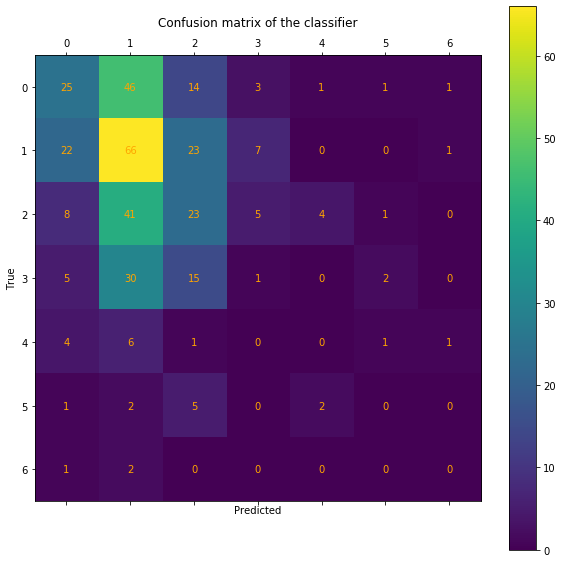

In [23]:
def confusion_matrix_heatmap(testTrue, testPred):
    """Function to plot a confusion matrix"""
    labels = list(set(testPred))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(testTrue, testPred, labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=0)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="orange")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
confusion_matrix_heatmap(Y_test, Y_lr)